<a href="https://colab.research.google.com/github/nicholashagemann/lambdalectures/blob/main/DS29_GP_Unit2_Sprint2_Module2_Nivi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OVERVIEW**
1. Announcements
2. GINI Impurity
3. Decision Trees
4. Random Forest
5. Ordinal Encoding

# Random Forests

- use scikit-learn for **random forests**
- do **ordinal encoding** with high-cardinality categoricals
- understand how categorical encodings affect trees differently compared to linear models
- understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth

In [ ]:
%%capture

import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Wrangle Data

In [ ]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, 
                              na_values=[0, -2.000000e-08],
                              parse_dates=['date_recorded']),
                  pd.read_csv(tv_path)).set_index('id')
  else:
    df = pd.read_csv(fm_path, 
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')

  # Drop constant columns
  df.drop(columns=['recorded_by'], inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns
  dupe_cols = [col for col in df.head(15).T.duplicated().index
               if df.head(15).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)             

  return df

df = wrangle(fm_path=DATA_PATH+'waterpumps/train_features.csv',
             tv_path=DATA_PATH+'waterpumps/train_labels.csv')

X_test = wrangle(fm_path=DATA_PATH+'waterpumps/test_features.csv')

In [ ]:
df.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pump_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572.0,6000.0,1390.0,34.938093,-9.856322,NaN,Lake Nyasa,Iringa,11,5.0,109.0,True,VWC,False,1999.0,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,12.0
8776.0,NaN,1399.0,34.698766,-2.147466,NaN,Lake Victoria,Mara,20,2.0,280.0,NaN,Other,True,2010.0,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3.0
34310.0,25.0,686.0,37.460664,-3.821329,NaN,Pangani,Manyara,21,4.0,250.0,True,VWC,True,2009.0,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,4.0
67743.0,NaN,263.0,38.486161,-11.155298,NaN,Ruvuma / Southern Coast,Mtwara,90,63.0,58.0,True,VWC,True,1986.0,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,27.0
19728.0,NaN,NaN,31.130847,-1.825359,NaN,Lake Victoria,Kagera,18,1.0,NaN,True,NaN,True,NaN,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,NaN


# II. Split Data

## Split TV from FM

TV - Target Variable
FM - Feature matrix

In [ ]:
target = 'status_group'
y = df[target]
X = df.drop(columns=target)

# Training-Validation Split

- Randomized split

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

# III. Establish Baseline

This is a **classification** problem, our baseline will be **accuracy**. 

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


# IV. Build Model(s)

- Missing values
- Categorical values

In [ ]:
tree_model = make_pipeline(OrdinalEncoder(),
                           SimpleImputer(strategy = 'mean'),
                           DecisionTreeClassifier(random_state=42,max_depth = 12))

In [ ]:
tree_model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group...
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                             

In [ ]:
tree_model.named_steps['decisiontreeclassifier'].get_depth()

15

In [ ]:
rf_model = make_pipeline(OrdinalEncoder(),
                           SimpleImputer(strategy = 'mean'),
                           RandomForestClassifier(random_state=42,max_depth = 14))

In [ ]:
rf_model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=14, max_features='auto',
                                   

# V. Check Metrics

In [ ]:
print('Tree training accuracy without max_depth param',tree_model.score(X_train,y_train))
print('Tree validation accuracy without max_depth param',tree_model.score(X_val,y_val))


Tree training accuracy without max_depth param 0.7948820471811275
Tree validation accuracy without max_depth param 0.7551346801346801


TRee without depth:
training acc : 99%
validation acc = 75%

In [ ]:
print('RF training accuracy',rf_model.score(X_train,y_train))
print('RF validation accuracy ',rf_model.score(X_val,y_val))


RF training accuracy 0.8477030240535365
RF validation accuracy  0.7956228956228957


RF without depth:
training acc: 99%
validation: 80%

# VI. Tune Model

In [ ]:
depths = range(2,20,2)
train_acc = []
val_acc =[]    

for d in depths:
  tree_model = make_pipeline(OrdinalEncoder(),
                           SimpleImputer(strategy = 'mean'),
                           DecisionTreeClassifier(random_state=42,max_depth = d))
  tree_model.fit(X_train,y_train)
  train_acc.append(tree_model.score(X_train,y_train))
  val_acc.append(tree_model.score(X_val,y_val))

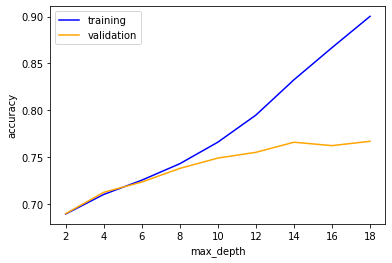

In [ ]:
plt.plot(depths,train_acc,color='blue',label='training')
plt.plot(depths,val_acc,color='orange',label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# VII. Communicate Results

In [ ]:
importances = tree_model.named_steps['decisiontreeclassifier'].feature_importances_
features = tree_model.named_steps['ordinalencoder'].get_feature_names()
feat_imp = pd.Series(importances,index=features).sort_values()

Text(0.5, 0, 'Reduction in Gini Impurity')

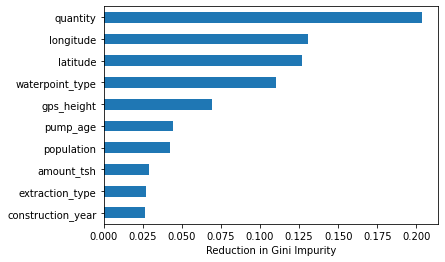

In [ ]:
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity')

In [ ]:
importances = rf_model.named_steps['randomforestclassifier'].feature_importances_
features = rf_model.named_steps['ordinalencoder'].get_feature_names()
feat_imp = pd.Series(importances,index=features).sort_values()

Text(0.5, 0, 'Reduction in Gini Impurity')

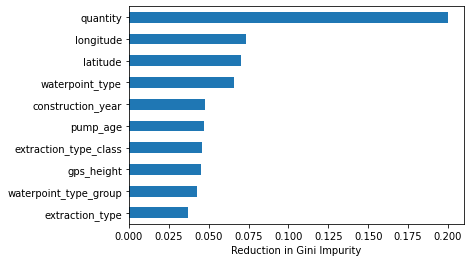

In [ ]:
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity')

DIY!!
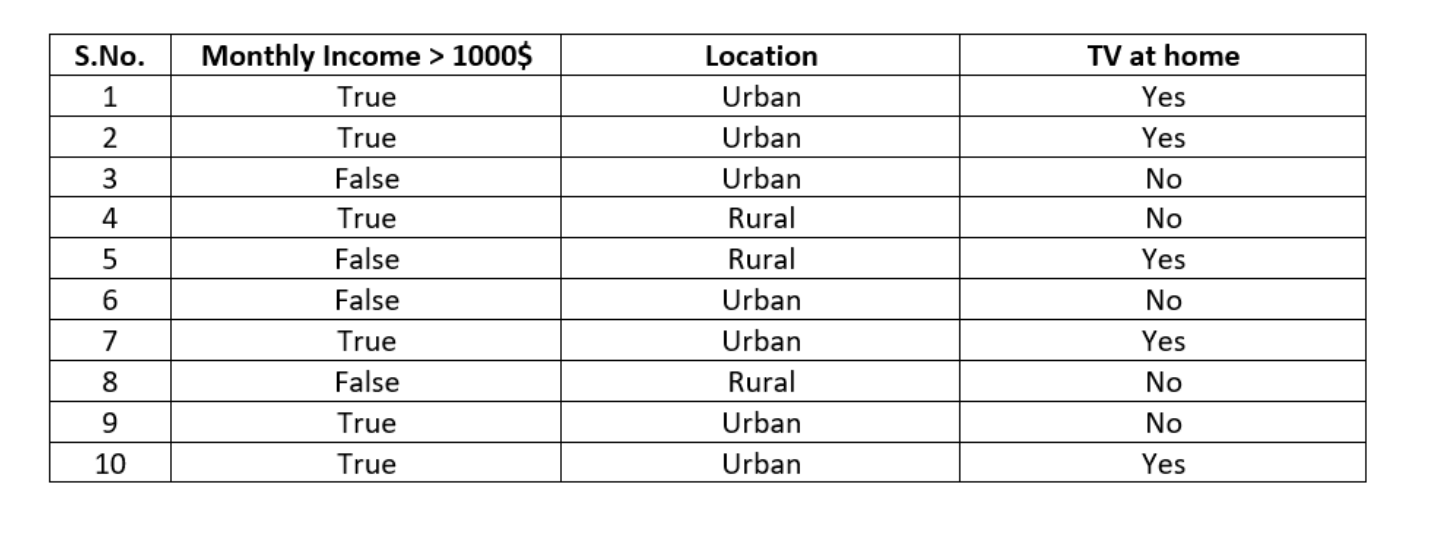